In [1]:
import numpy as np
import pandas as pd 
from xgboost import XGBRegressor 
from sklearn.model_selection import TimeSeriesSplit
import warnings                                  
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
from sklearn.preprocessing import StandardScaler
from itertools import product                   
from sklearn.model_selection import cross_val_score
from scipy.optimize import minimize         
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("ts_train.csv")
test = pd.read_csv("ts_test.csv")

In [3]:
def select_ts(index):
    return (train[train.tsID == index].copy(),
            test[test.tsID == index].copy())

In [4]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, index = 0, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.index = index
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            if (i+self.slen) >= len(self.series):
                a = len(self.series)-1
            else:
                a = i+self.slen
            sum += float(self.series[a] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [5]:
def tscrossvalid(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [6]:
def optimizer(data):
    # initializing model parameters alpha, beta and gamma
    x = [0, 0, 0] 

    # Minimizing the loss function 
    opt = minimize(tscrossvalid, x0=x, 
                   args=(data, mean_squared_error), 
                   method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
                  )

    # Take optimal values...
    alpha_final, beta_final, gamma_final = opt.x
    return(alpha_final, beta_final, gamma_final)

In [7]:
def main(train, test, seas_am):
    
    data = np.array(train.ACTUAL)
    alpha_final, beta_final, gamma_final = optimizer(data)    
    
    model = HoltWinters(series=data, slen=350, 
                alpha=alpha_final, beta=beta_final, 
                gamma=gamma_final, n_preds=len(test))
    model.triple_exponential_smoothing()
    
    pred = model.result[-len(test):]
    df = pd.Series(pred, index = test.ID)
    return df

In [8]:
test_prim = None

In [9]:
train_init, test_init = select_ts(1)
test_1 = main(train_init, test_init, 350)

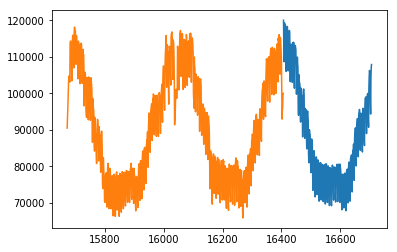

In [10]:
plt.plot(test_1+5500)
plt.plot(train_init.ID, train_init.ACTUAL)

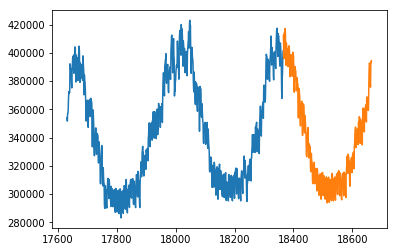

In [11]:
train_2, test_2 = select_ts(2)
plt.plot(train_2.ID, train_2.ACTUAL)
test_2 = main(train_2, test_2, 34)
plt.plot(test_2+3000)

In [12]:
test_prim = test_1

In [13]:
test_prim = test_prim.append(test_2)

In [14]:
for i in range(3, 23):
    print(i)
    seas_am = 365

    train_i, test_i = select_ts(i)
    test_i = main(train_i, test_i, seas_am)
    test_prim = test_prim.append(test_i)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [15]:
helper = pd.read_csv("helper.csv")

In [16]:
ovf = (650*np.array(helper.value) + 450*np.array(test_prim))/(650+450)
ovfx = np.array(test_prim)

In [17]:
dfxx = pd.Series(ovf, index = test_prim.index)
dfx = pd.Series(ovfx, index = test_prim.index)

In [18]:
dfxx.to_csv("primxx.csv")
dfx.to_csv("primx.csv")

In [19]:
from sklearn.model_selection import TimeSeriesSplit

In [20]:
class HWM:
    def __init__(self, data, season_amount, n_step, alpha=0.3, beta = 0.5, gamma = 0.4):
        self.data = data
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_step = n_step
        self.L = season_amount
        
    def init_trend(self, data):
        '''
        Initializes the starter trend based 
        on average of trend averages across seasons.
        '''
        
        all_trend = 0
        for i in range(self.L):
            if i+self.L >= len(self.data):
                a = len(self.data)-1
            else:
                a = i+self.L
            all_trend += (data[a] - data[i])/self.L
        return all_trend / self.L
    
    def init_seasonality(self, data):
        '''
        1. Get the average level of the seasons
        2. Divide observation by seasonal mean
        3. Average the numbers from the previous step based on amount of seasons
        '''
        seasonality = {}
        seasonal_mean = []
        n_seasons = int(len(data)/self.L)
        
        # Get the season means
        for s_i in range(n_seasons):
            seasonal_mean.append(sum(data[self.L*s_i:self.L*s_i+self.L])/self.L)

            
        # init values
        for i in range(self.L):
            sum_season = []
            for s_i in range(n_seasons):
                dat_compt = data[self.L*s_i+i]
                mean_compt = seasonal_mean[s_i]
                season_compt = dat_compt - mean_compt
                sum_season.append(season_compt)
            sum_season_all = np.sum(sum_season)
            seasonality[i] = sum_season_all/n_seasons
        return seasonality
        
    
    def smooth(self):
        pred = []
        seasonality = self.init_seasonality(self.data)
        for i in range(len(self.data) + self.n_step):
            #ruleset for initializing the values
            if i ==0:
                smoothened = self.data[0]
                trend = self.init_trend(self.data)
                pred.append(smoothened)
                
            #ruleset for forecasting
            elif i>=self.n_step:
                window = i-len(self.data)+1
                pred.append((smoothened + trend * window) 
                            + seasonality[i%self.L])
            
            #adapt the trends, seasonalities, etc.
            else:
                level = self.data[i]
                smoothened_p = smoothened

                smoothened = (self.alpha*(level - seasonality[i%self.L])
                              +(1-self.alpha)*(smoothened_p + trend))
                                          
                trend = (self.beta * (smoothened - smoothened_p) + 
                         (1-self.beta) * trend)
                
                seasonality[i%self.L] = (self.gamma*(level - smoothened) + 
                                        (1-self.gamma)* seasonality[i%self.L])
                
                pred.append(smoothened + trend + seasonality[i%self.L])
            
        return pred

In [21]:
prim2 = None

In [22]:
def manual_trainer(i, s= 365, alpha = 0.03, beta = 0.007, gamma = 0.1):
    train_i, test_i = select_ts(i)
    model_i = HWM(data = np.array(train_i.ACTUAL), 
                 season_amount = s, 
                 n_step = 30, 
                 alpha= alpha, 
                 beta = beta, 
                 gamma = gamma)
    
    pred_i = model_i.smooth()[:300]
    plt.plot(train_i.ID, train_i.ACTUAL)
    plt.plot(test_i.ID, pred_i)
    return pd.Series(pred_i, index = test_i.ID)

def man_test_2(i, d = 0):
    train_i, test_i = select_ts(i)
    test_2 = main(train_i, test_i, 365) + d
    plt.plot(train_i.ID, train_i.ACTUAL)
    plt.plot(test_2)
    return test_2

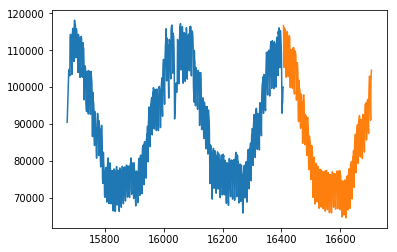

In [23]:
#prim2 = manual_trainer(1, 356, 0.02, 0.835, 0.1)
prim2 = man_test_2(1, 2200)

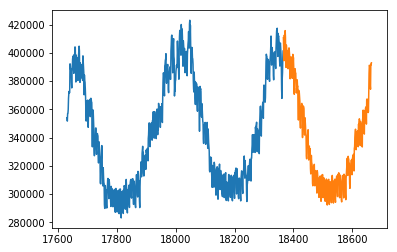

In [24]:
#prim2 = prim2.append(manual_trainer(2))
prim2 = prim2.append(man_test_2(2, 1500))

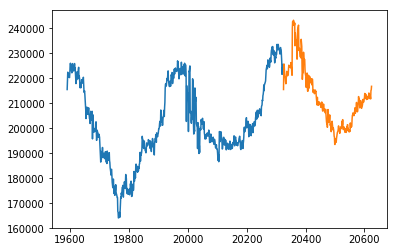

In [25]:
prim2 = prim2.append(manual_trainer(3, 366, 0.2, 0.2, 0.5))
#prim2 = prim2.append(man_test_2(3, -3400))

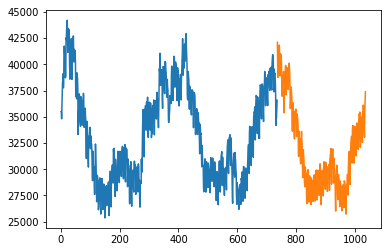

In [26]:
#prim2 = prim2.append(manual_trainer(4, 364, 0.1, 0.053, 0.1))
prim2 = prim2.append(man_test_2(4, 1200))

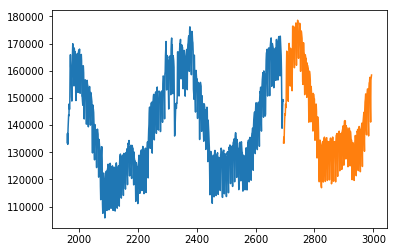

In [27]:
prim2 = prim2.append(manual_trainer(5, 364, 0.78, 0.0493, 0.1))
#prim2 = prim2.append(man_test_2(5, 700))

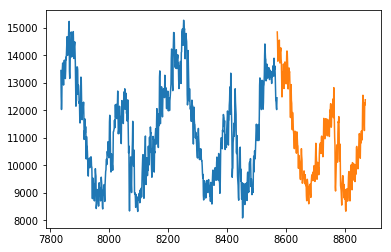

In [28]:
#prim2 = prim2.append(manual_trainer(6, 365, 0.0869, 0.9, 0.2))
prim2 = prim2.append(man_test_2(6))

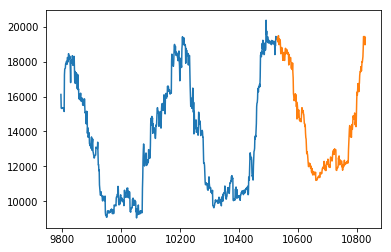

In [29]:
#prim2 = prim2.append(manual_trainer(7, 366, 0.2, 0.0022, 0.1))
prim2 = prim2.append(man_test_2(7, -500))

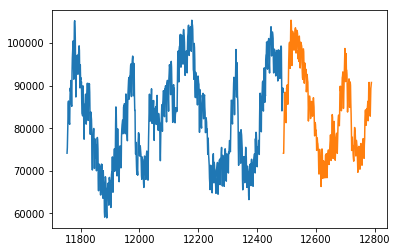

In [30]:
prim2 = prim2.append(manual_trainer(8, 365, 0.5, 0.31, 0.2))
#prim2 = prim2.append(man_test_2(8, 0))

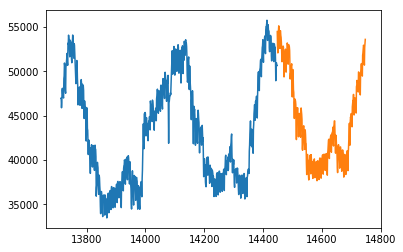

In [31]:
#prim2 = prim2.append(manual_trainer(9, 365, 0.1008, 0.1, 0.2))
prim2 = prim2.append(man_test_2(9, 0))

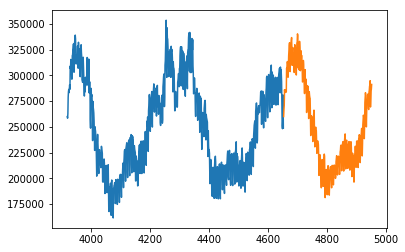

In [32]:
prim2 = prim2.append(manual_trainer(10, 365, 0.02, 0.008, 0.1))
#prim2 = prim2.append(man_test_2(10, 2500))

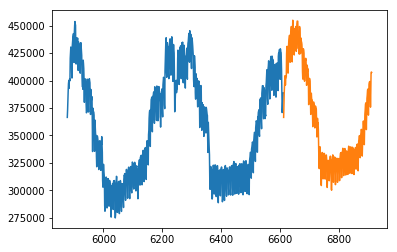

In [33]:
prim2 = prim2.append(manual_trainer(11, 365, 0.002, 0.65, 0.2))

In [34]:
train_12, test_12 = select_ts(12)

In [35]:
test_2 = main(train_12, test_12, 365) +5200

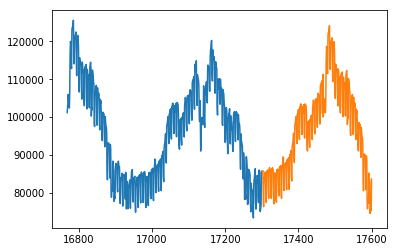

In [36]:
plt.plot(train_12.ID, train_12.ACTUAL)
plt.plot(test_2)

In [37]:
prim2 = prim2.append(test_2)

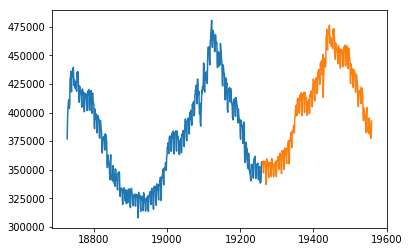

In [38]:
prim2 = prim2.append(man_test_2(13, -5000))

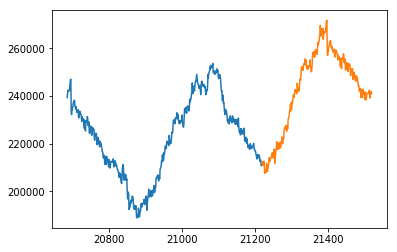

In [39]:
prim2 = prim2.append(man_test_2(14, -500))

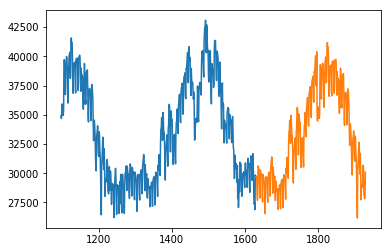

In [56]:
prim2 = prim2.append(man_test_2(15, -850))

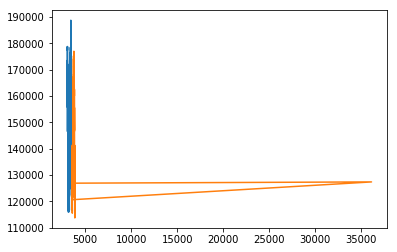

In [41]:
prim2 = prim2.append(man_test_2(16, -1000))

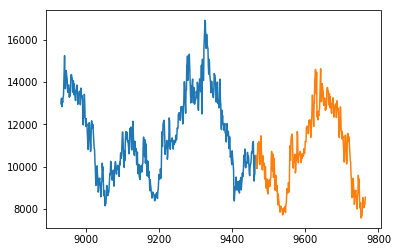

In [42]:
prim2 = prim2.append(man_test_2(17, -2600))

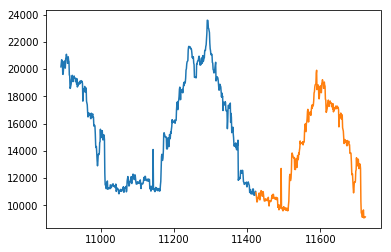

In [43]:
prim2 = prim2.append(man_test_2(18, -1000))

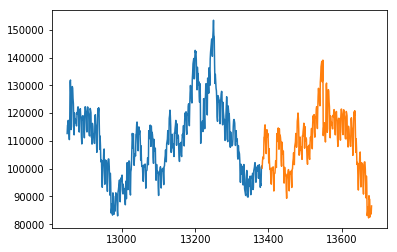

In [44]:
prim2 = prim2.append(man_test_2(19, -5000))

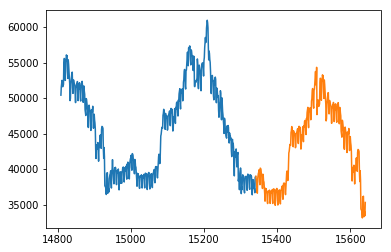

In [45]:
prim2 = prim2.append(man_test_2(20, -600))

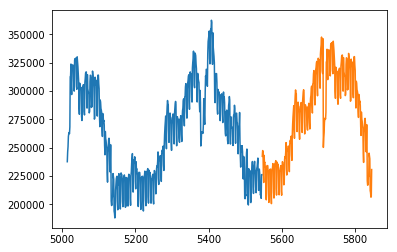

In [46]:
prim2 = prim2.append(man_test_2(21, -19000))

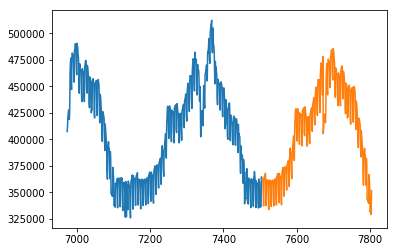

In [47]:
prim2 = prim2.append(man_test_2(22, -1000))

In [48]:
prim2

ID
16407    116733.181612
16408    109299.294197
16409    105340.642138
16410    116033.908818
16411    115812.038110
16412    115558.351248
16413    115492.655067
16414    115194.660443
16415    107081.128504
16416    102691.516168
16417    113689.689175
16418    114200.436253
16419    114399.272505
16420    115022.057171
16421    113891.967612
16422    105813.154811
16423    102858.323318
16424    108667.808318
16425    109217.319570
16426    113570.399537
16427    113917.507145
16428    113497.876900
16429    107074.660143
16430     99890.896509
16431    109640.358166
16432    110131.937357
16433    110125.338983
16434    110135.276803
16435    109410.869262
16436    101705.597388
             ...      
7776     383327.921820
7777     408330.974285
7778     403278.104901
7779     397024.958254
7780     393419.415386
7781     388080.136637
7782     366035.045457
7783     356774.745196
7784     386068.023270
7785     386715.956119
7786     391529.362850
7787     385177.775589
7788    

In [49]:
ovf2 = (6*np.array(helper.value) + 
        5*np.array(prim2))/(5+6)
df = pd.Series(ovf2, index = prim2.index)
df.to_csv("prim3.csv")

In [50]:
ovf3 = (7.5*np.array(helper.value) + 3.8*np.array(test_prim) + 5*np.array(prim2))/(3.8+5+7.5)
dfn = pd.Series(ovf3, index = test_prim.index)
dfn.to_csv("prim4.csv")

In [51]:
helper2 = pd.read_csv("sub.csv")

In [52]:
hp2v = np.array(helper2.value)

In [53]:
ovf4 = (ovf2*5.8 + ovf3*4.2+0.1*hp2v)/10.1

In [54]:
df = pd.Series(ovf7, index = prim2.index)
df.to_csv("prim5.csv")